# Genetic Algorithms

### A whirlwind tour of bio-inspired computing algorithms

#### Quentin Caudron

[Genetic algorithms](https://en.wikipedia.org/wiki/Genetic_algorithm), famously described as "the second-best method for all optimisation problems", are flexible and powerful, despite a potentially high computational cost and various quirks. They are good when the space of solutions is enormous, and the space cannot be searched; they allow all sorts of constraints and generative models, which may lead to a problem where traversal of parameter space may be difficult or impossible to other optimisation methods.

### The inspiration

The general philosophy behind genetic algorithms is rooted in [natural selection](https://en.wikipedia.org/wiki/Natural_selection). As with many things biological, context is important, so here we'll describe one particular implementation of a genetic algorithm.

We begin with a population of possible solutions to a problem. Solutions are treated as individual living things : the parameters which make up the solution are the solution's "genome", and this genome determines the "fitness" of the solution. In discrete time, solutions come together in pairs to reproduce, and their children inherit the attributes of their parents.

In [1]:
from time import time
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tnrange
C = sns.color_palette("deep", 8)

In [31]:
def fitness(individual, target):
    """Loss function - in this case, the L2 norm."""
    error0 = np.sum((objective(individual) - objective(target))**2)
    #error1 = np.sum((np.diff(objective(individual)) - np.diff(objective(target)))**2)
    return error0 #+ error1 / 2

def fitness_wrapper(args):
    return fitness(*args)

def initialise(N, domain):
    """Initialise a population of random individuals."""
    return np.concatenate([np.random.uniform(d[0], d[1], (N, 1)) for d in domain], axis=1)

def selection(population, fraction, target, how="best"):
    """Perform selection on the population.
    If <how> is "best", return the <fraction> of the population with the 
    highest fitness. If <how> is "linear" or "exp", select individuals
    probabilistically proportional to their fitness or its exponential, respectively.
    """
    
    fitnesses = np.array(pool.map(fitness_wrapper, [(p, target) for p in population]))
    #fitnesses = np.array([fitness(individual, target) for individual in population])
    
    if how == "best":
        sorted_by_fitness = np.argsort(fitnesses)
        return population[sorted_by_fitness[:int(len(population)*fraction)]]
    else:
        raise NotImplementedError
        
def crossover(selected, desired_population_size):
    """Perform genetic crossover of the selected individuals."""
    
    # Select pairs of parents from the selected individuals
    parent_pairs = np.random.randint(0, len(selected), (desired_population_size, 2))
    
    # For each pair of parents, select from which parent will come each gene
    genotype_from_idx = np.random.randint(0, 2, (desired_population_size, len(selected[0])))
    
    # Perform crossover
    offspring = np.zeros((desired_population_size, len(selected[0])))
    genome_combinations = selected[parent_pairs]
    for idx, genomes in enumerate(zip(genome_combinations, genotype_from_idx)):
        parents, genes = genomes
        offspring[idx] = [parents[gene][i] for i, gene in enumerate(genes)]
        
    return np.array(offspring)

def mutation(offspring, mutation_rate, constraints=None):
    """Mutate genotypes slightly."""
    
    mutated = offspring + np.random.normal(0, mutation_rate * offspring.std(0), ((len(offspring), len(offspring[0]))))
    
    if constraints:
        for idx, constraint in enumerate(constraints):
            if constraint is not None:
                if np.any(mutated[:, idx] < constraint[0]):
                    loc = np.where(mutated[:, idx] < constraint[0])[0]
                    mutated[loc, idx] = constraint[0]
                if np.any(mutated[:, idx] > constraint[1]):
                    loc = np.where(mutated[:, idx] > constraint[1])[0]
                    mutated[loc, idx] = constraint[1]
                    
    return mutated

def advance_generation(population, selection_rate, target, mutation_rate, constraints):
    
    selected = selection(population, selection_rate, target)
    offspring = crossover(selected, len(population))
    population = mutation(offspring, mutation_rate, constraints)
    
    return population

def plot_genetic_algorithm(N, generations, selection_rate, mutation_rate, target, domain, constraints, tolerance):
    
    plt.figure(figsize=(12, 12))

    population = initialise(N, domain)
    target_vector = objective(target)

    plt.subplot2grid((4, len(domain)), (0, 0), colspan=len(domain))
    plt.plot(objective(target), lw=5)
    subsample = np.random.choice(N, min(200, N), replace=False)
    for i in population[subsample]:
        plt.plot(objective(i), c=C[2], alpha=20/len(subsample))
    plt.title("Initialisation of the population")
    plt.xlim(0, len(target_vector))


    plt.subplot2grid((4, len(domain)), (1, 0), colspan=len(domain))
    means = []
    errors = []
    for i in tnrange(generations):

        population = advance_generation(population, selection_rate, target, mutation_rate, constraints)

        # Log convergence information
        means.append(population.mean(0))
        errors.append(np.sum((objective(means[-1]) - target_vector)**2))
        
        if errors[-1] < tolerance:
            break

    plt.plot(objective(target), lw=10, alpha=0.5)
    subsample = np.random.choice(N, min(200, N), replace=False)
    for i in population[subsample]:
        plt.plot(objective(i), c=C[2], alpha=20/len(subsample))
    plt.title("After {} generations".format(len(errors)))
    plt.xlim(0, len(target_vector))


    for i in range(len(domain)):
        plt.subplot2grid((4, len(domain)), (2, i))
        plt.title("Parameter {}".format(i))
        plt.plot(np.array(means)[:, i], lw=3, c=C[i % len(C)])
        plt.axhline(target[i], ls="--", c=C[i % len(C)])
        #plt.legend(list(range(len(population[0]))))
        plt.xlim(0, len(errors) * 1.2)

    
    plt.subplot2grid((4, len(domain)), (3, 0), colspan=len(domain))
    plt.title("Error")
    plt.semilogy(np.array(errors), lw=3)
    plt.xlim(0, len(errors)-1)


    plt.tight_layout()
    
    return population.mean(0)

pool = Pool(8)

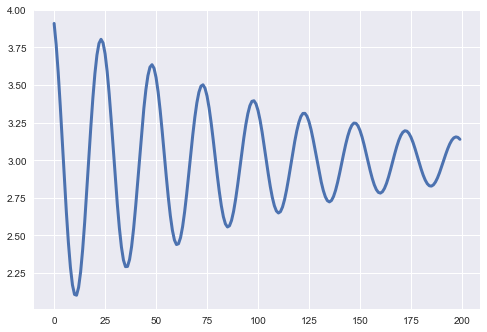

In [34]:
def objective(parameters):
    """Target function."""
    a, b, c, d, e = parameters
    t = np.linspace(0, 2 * np.pi, 200)
    return a * np.sin(e * t + b) * np.exp(d * t) + c

target = [1, 2, 3, -0.3, 8]

plt.plot(objective(target), lw=3)

In [ ]:
N = 10000
generations = 100

selection_rate = 250 / N
mutation_rate = 0.5
tolerance = 1e-5

domain = [(-5, 20), (0, 8), (0, 200), (-1, 0), (-5, 10)]

constraints = domain
constraints[1] = (1, 3)

pop = plot_genetic_algorithm(N, generations, selection_rate, mutation_rate, target, domain, None, tolerance)

In [ ]:
def objective(parameters):
    """Target function."""
    a, b, c, d, e = parameters
    t = np.linspace(0, 2 * np.pi, 200)
    return a * np.sin(e * t + b) * np.exp(d * t) + c

target = [1, 2, 3, -0.3, 8]

plt.plot(objective(target), lw=3)